# Analyzing NSW Public Transports Usage - Opal Cards' Tap-ons and Tap-offs

## Problem Tasks: 
- Examine the Opal usage data from Transport NSW and identify the patterns of different transport modes including bus, rail and ferry. 
- Having collected data about average income and age range of NSW people, we apply a suitable analysis technique in order to decide if there is a relationship between transport usage and a specific factor.

# Dataset:
* **_Relationship between Tap-ons and Tap-off Opal Card_**
* **_Prediction of Transport Uses Based on Personal Weekly Income_** 
* **_Prediction of Transport Uses Based on Age Group_**
* **_Identifying and Clustering the Uses of Transport Modes_**

# Import Necessary Functions

In [3]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std

# Plot
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline
from sklearn.metrics import plot_confusion_matrix

# Functions used for linear regression
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import metrics

# Functions used for logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# Functions used for K-Nearest Neighbours Classifier
from sklearn.neighbors import KNeighborsClassifier

# Functions used for Naive Bayes
from sklearn.naive_bayes import GaussianNB

# Functions used for Neural Network
from sklearn.neural_network import MLPClassifier

# Functions used for Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from scipy.spatial.distance import pdist 

# Ignore Warning
import warnings
warnings.filterwarnings("ignore")

# Identifying and Clustering the Uses of Transport Modes

## Data Summary and Manipulation

We use the dataset taken from the [OpenData of Transport NSW](https://opendata.transport.nsw.gov.au/dataset/opal-trips-all-modes) which recorded the monthly transport uses from July 2016 to July 2021. The transport modes included in the dataset that we will analyse on are train, bus, ferry, light rail, and metro. The dataset is in the `xlsx` format, and the file name of it is `transportmodecount`. We will use this dataset to identify some common pattern between the recorded months, and also cluster these months to see if there is any high transport-use volume months.

*_Process:_*
- Data summary and manipulation: clean the null values in the metro field by filling 0; do simple summary such as decribing the mean, max and min of each field in the dataset.
- Data exploration: We explore the trend of the transport uses (increase or decrease on a period), then do clustering to see if there is any specific group of transport usage.

*_Aim:_*
To explore if there is any specific month that citizens use transport frequently; this then could be use to improve the transport service such as adding more trips on the high-demand months, or could be used to analyse the factors or reasons why the uses of service decreased on a certain period.

### Import File and Create Dataframe

In [4]:
# import the excel file
df_transport = pd.read_excel("File/transportmodecount.xlsx",index_col=0)

# Transpose row to column
df_transport = df_transport.T

# remove the last row "Grand Total"
df_transport = df_transport.drop("Grand Total", axis=0)

# remove time from the index
df_transport.index = pd.to_datetime(df_transport.index).date

df_transport.head(6)

Transport Modes,Bus,Ferry,Light rail,Metro,Train,Grand Total
2016-07-01,21198509.0,1213712.0,827732.0,NaN,28819249.0,52059202.0
2016-08-01,25210772.0,1095055.0,840800.0,NaN,32393980.0,59540607.0
2016-09-01,23011540.0,1143718.0,758073.0,NaN,30648352.0,55561683.0
2016-10-01,23095302.0,1281152.0,776960.0,NaN,30106833.0,55260247.0
2016-11-01,24422383.0,1302501.0,705265.0,NaN,31318279.0,57748428.0
2016-12-01,20880865.0,1506986.0,726521.0,NaN,28189584.0,51303956.0


### Deal with Outliers

We will check if there is any NaN value.

In [7]:
df_transport.isna().sum()

Transport\nModes
Bus             0
Ferry           0
Light rail      0
Metro          34
Train           0
Grand Total     0
dtype: int64

* ***Comment:*** There are 34 null values in the Metro field. The metro service in NSW began from 2019, every month before 2019 therefore will not have data in the metro field. As such, we will fill in 0 to all the `NaN` values.

In [8]:
df_transport = df_transport.fillna(0)

### Data Summary

In [9]:
df_transport.shape

(61, 6)

In [10]:
df_transport.describe()

Transport Modes,Bus,Ferry,Light rail,Metro,Train,Grand Total
count,6.100000e+01,6.100000e+01,6.100000e+01,6.100000e+01,6.100000e+01,6.100000e+01
mean,2.115637e+07,1.062945e+06,9.882385e+05,5.808296e+05,2.755950e+07,5.134788e+07
std,5.740788e+06,4.100610e+05,4.227730e+05,7.629534e+05,8.269252e+06,1.415594e+07
min,5.094308e+06,8.083200e+04,1.937200e+05,0.000000e+00,5.266764e+06,1.108138e+07
25%,1.703207e+07,6.772650e+05,8.152370e+05,0.000000e+00,2.103861e+07,4.195683e+07
50%,2.306499e+07,1.179849e+06,8.587270e+05,0.000000e+00,3.027515e+07,5.624810e+07
75%,2.532301e+07,1.302501e+06,9.986650e+05,1.162246e+06,3.345712e+07,6.048659e+07
max,2.874222e+07,1.738083e+06,2.180906e+06,2.206777e+06,3.756212e+07,6.844949e+07


## Data Exploration

* **Plotting the trends of all transport modes**

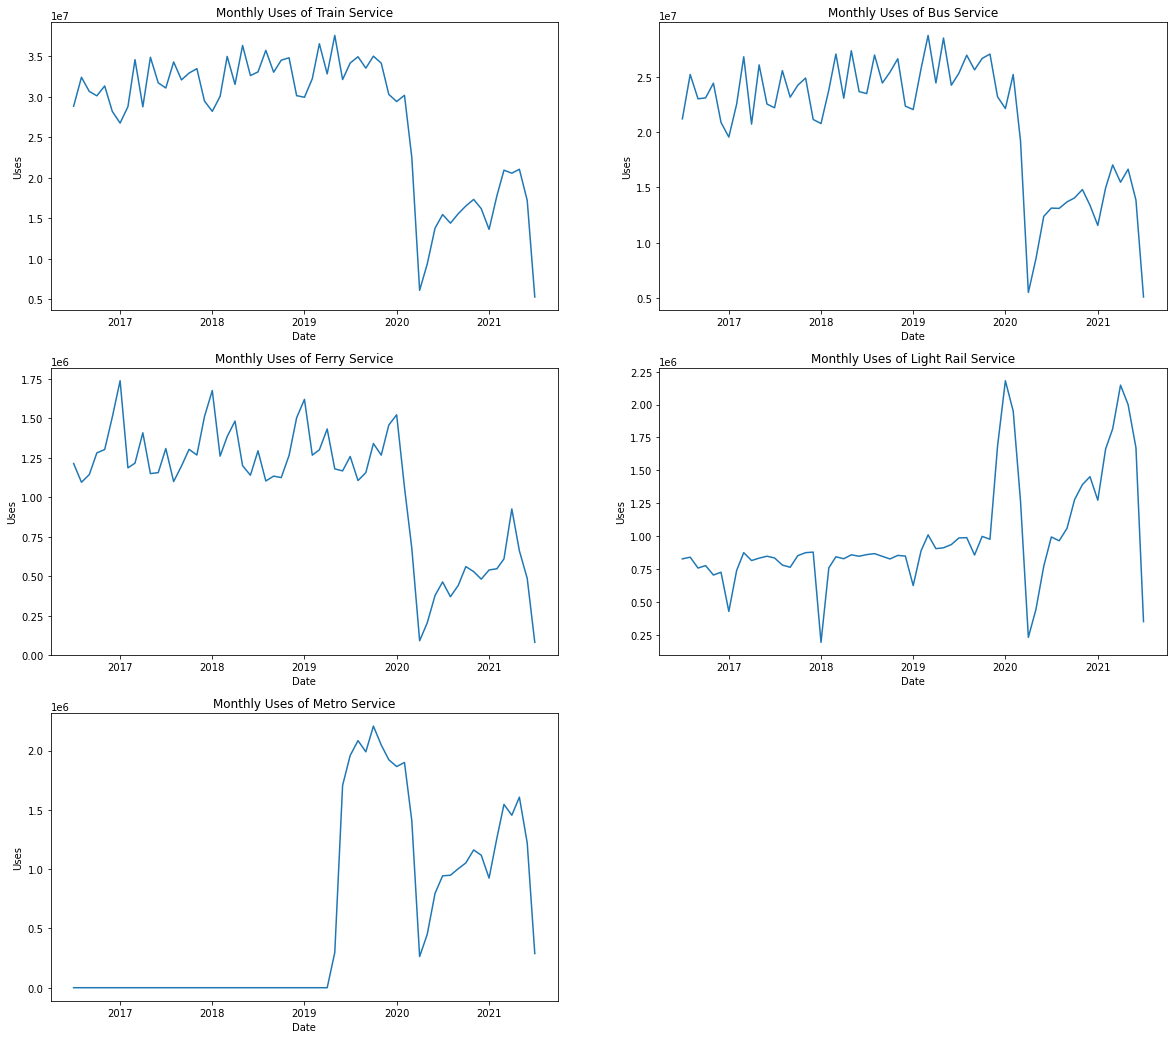

In [11]:
plt.figure(figsize=(20,18))

# Train service
plt.subplot(3,2,1)
plt.title("Monthly Uses of Train Service")
plt.xlabel("Date")
plt.ylabel("Uses")
plt.plot(df_transport["Train"])

# Bus service
plt.subplot(3,2,2)
plt.title("Monthly Uses of Bus Service")
plt.xlabel("Date")
plt.ylabel("Uses")
plt.plot(df_transport["Bus"])

# Ferry service
plt.subplot(3,2,3)
plt.title("Monthly Uses of Ferry Service")
plt.xlabel("Date")
plt.ylabel("Uses")
plt.plot(df_transport["Ferry"])

# Light Rail service
plt.subplot(3,2,4)
plt.title("Monthly Uses of Light Rail Service")
plt.xlabel("Date")
plt.ylabel("Uses")
plt.plot(df_transport["Light rail"])

# Metro service
plt.subplot(3,2,5)
plt.title("Monthly Uses of Metro Service")
plt.xlabel("Date")
plt.ylabel("Uses")
plt.plot(df_transport["Metro"])

* ***Interpretation:*** 
The most population public transport is Train service following by Bus, then Ferry and Light Rail. The Metro service came into practice recently around the middle of year 2019. In 2020 in each graph, we can see the public transport has dropped dramatically since the Covid19 and lockdown started. After few months, everyone slowly use the public transport again as a matter of consequential restrictions. The plots start increasing again in the amount of using public transport included Train, Ferry, Bus, Light Rail and Metro. The least popular transport within 5 of them is Ferry as its peak is just 1.75e+06 while the peak of train equals 3.7e+07, bus equals around 3e+07, light rail is 2.25e+06 and more than 2.0e+06 in Metro. 

* **Clustering**

In [12]:
#Drop the column "Grand Total" for clustering
transportmodes = df_transport.drop(columns=['Grand Total'])
transportmodes.head(6)

Transport Modes,Bus,Ferry,Light rail,Metro,Train
2016-07-01,21198509.0,1213712.0,827732.0,0.0,28819249.0
2016-08-01,25210772.0,1095055.0,840800.0,0.0,32393980.0
2016-09-01,23011540.0,1143718.0,758073.0,0.0,30648352.0
2016-10-01,23095302.0,1281152.0,776960.0,0.0,30106833.0
2016-11-01,24422383.0,1302501.0,705265.0,0.0,31318279.0
2016-12-01,20880865.0,1506986.0,726521.0,0.0,28189584.0


In [13]:
dist = pdist(transportmodes,'euclidean')
linkage_matrix = linkage(dist, method = 'complete')

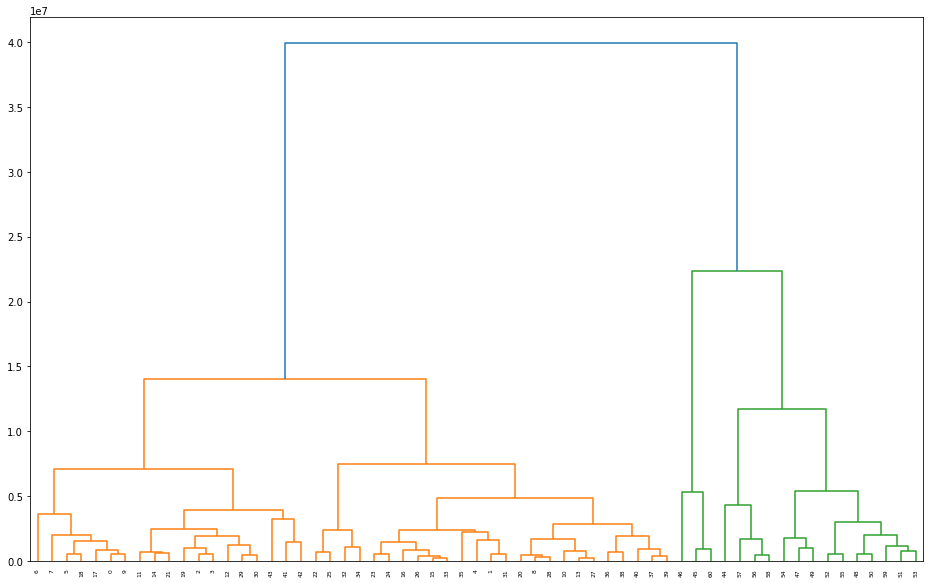

In [126]:
# Dendrogram for hierarchical clustering
plt.figure(figsize=(16,10))
dendrogram(linkage_matrix)
plt.show()

In [14]:
labels = cut_tree(linkage_matrix, n_clusters=3)
transportmodes['label'] = labels
transportmodes

Transport Modes,Bus,Ferry,Light rail,Metro,Train,label
2016-07-01,21198509.0,1213712.0,827732.0,0.0,28819249.0,0
2016-08-01,25210772.0,1095055.0,840800.0,0.0,32393980.0,0
2016-09-01,23011540.0,1143718.0,758073.0,0.0,30648352.0,0
2016-10-01,23095302.0,1281152.0,776960.0,0.0,30106833.0,0
2016-11-01,24422383.0,1302501.0,705265.0,0.0,31318279.0,0
...,...,...,...,...,...,...
2021-03-01,17032074.0,609963.0,1816634.0,1546314.0,20925803.0,1
2021-04-01,15471111.0,926107.0,2147622.0,1454810.0,20552499.0,1
2021-05-01,16650452.0,660979.0,1999285.0,1607509.0,21038609.0,1
2021-06-01,13859329.0,486379.0,1672701.0,1222024.0,17193476.0,1


In [15]:
transportmodes['label'].value_counts()

0    44
1    14
2     3
Name: label, dtype: int64

In [16]:
#Months labeled as cluster 2
transportmodes[transportmodes['label']==2]

Transport Modes,Bus,Ferry,Light rail,Metro,Train,label
2020-04-01,5504822.0,91230.0,232032.0,262852.0,6095725.0,2
2020-05-01,8549735.0,203728.0,443833.0,449327.0,9323674.0,2
2021-07-01,5094308.0,80832.0,351308.0,288173.0,5266764.0,2


In [17]:
#Months labeled as cluster 1
transportmodes[transportmodes['label']==1]

Transport Modes,Bus,Ferry,Light rail,Metro,Train,label
2020-03-01,19191569.0,677265.0,1264683.0,1408500.0,22506278.0,1
2020-06-01,12386023.0,377351.0,772279.0,795627.0,13762670.0,1
2020-07-01,13132371.0,463754.0,994370.0,943774.0,15446904.0,1
2020-08-01,13107189.0,369977.0,965468.0,948902.0,14385299.0,1
2020-09-01,13690626.0,441991.0,1059605.0,1003812.0,15556289.0,1
2020-10-01,14059038.0,560732.0,1277545.0,1052802.0,16502457.0,1
2020-11-01,14809745.0,529113.0,1391815.0,1162246.0,17317270.0,1
2020-12-01,13391873.0,481290.0,1452246.0,1117564.0,16173796.0,1
2021-01-01,11567325.0,539271.0,1273629.0,924685.0,13616536.0,1
2021-02-01,14964876.0,547260.0,1663207.0,1263058.0,17765453.0,1


In [18]:
#Months labeled as cluster 0
transportmodes[transportmodes['label']==0]

Transport Modes,Bus,Ferry,Light rail,Metro,Train,label
2016-07-01,21198509.0,1213712.0,827732.0,0.0,28819249.0,0
2016-08-01,25210772.0,1095055.0,840800.0,0.0,32393980.0,0
2016-09-01,23011540.0,1143718.0,758073.0,0.0,30648352.0,0
2016-10-01,23095302.0,1281152.0,776960.0,0.0,30106833.0,0
2016-11-01,24422383.0,1302501.0,705265.0,0.0,31318279.0,0
2016-12-01,20880865.0,1506986.0,726521.0,0.0,28189584.0,0
2017-01-01,19550895.0,1738083.0,428998.0,0.0,26735422.0,0
2017-02-01,22534683.0,1186315.0,740308.0,0.0,28767036.0,0
2017-03-01,26811115.0,1216242.0,875062.0,0.0,34566385.0,0
2017-04-01,20723045.0,1408468.0,815237.0,0.0,28745729.0,0


In [19]:
#Months with no metro usage (before the construction of the Metro service in NSW)
transportmodes[transportmodes['Metro']==0]

Transport Modes,Bus,Ferry,Light rail,Metro,Train,label
2016-07-01,21198509.0,1213712.0,827732.0,0.0,28819249.0,0
2016-08-01,25210772.0,1095055.0,840800.0,0.0,32393980.0,0
2016-09-01,23011540.0,1143718.0,758073.0,0.0,30648352.0,0
2016-10-01,23095302.0,1281152.0,776960.0,0.0,30106833.0,0
2016-11-01,24422383.0,1302501.0,705265.0,0.0,31318279.0,0
2016-12-01,20880865.0,1506986.0,726521.0,0.0,28189584.0,0
2017-01-01,19550895.0,1738083.0,428998.0,0.0,26735422.0,0
2017-02-01,22534683.0,1186315.0,740308.0,0.0,28767036.0,0
2017-03-01,26811115.0,1216242.0,875062.0,0.0,34566385.0,0
2017-04-01,20723045.0,1408468.0,815237.0,0.0,28745729.0,0


### Mean for each Cluster

In [20]:
transportmodes.groupby(['label']).agg('mean')

Transport Modes,Bus,Ferry,Light rail,Metro,Train
label,,,,,
0,2.427446e+07,1.290736e+06,8.978248e+05,4.086051e+05,3.222045e+07
1,1.452240e+07,5.479594e+05,1.410792e+06,1.175116e+06,1.733881e+07
2,6.382955e+06,1.252633e+05,3.423910e+05,3.334507e+05,6.895388e+06


* ***Comment:*** By observing the table, the first cluster (cluster 0) including all the moth with the highest number of uses in Train, Bus and Ferry, also the second highest uses of Light rail and Metro, on average. The lowest average of uses in transport service could be seen in the last cluster (cluster 2).

### Data Interpretation
From the hierarchical clustering of the data, we divided the data into 3 clusters, labeled [0,1,2], with 0 being approximately the cluster with the highest figures recorded - indicating months with the most frequent transport use, followed by 1 and finally 2 - the cluster with the lowest figures recorded, which indicates periods where people in NSW commute the least. 

There are 44 months labeled as cluster 0. Notably, all of these months were prior to 2021, with the vast majority being between 2016 and 2019 while only the first two months of 2020 are included of the cluster. 14 months are labeled as cluster 1, with 8 months in 2020 and the 6 first months of 2021. The 3 remaining months are part of cluster 2, the months with the least transport usage, which consists of April and May 2020 and July 2021. 

From the information collected and interpreted, we can see that public transport was considerably more popular in the earlier years of the study (2016 to 2019), and even the lack of metro service did not affect the numbers, as we could see that all the months before the introduction of the metro service are in cluster 0, the cluster with the highest numbers. 

The drop in the public transport usage figures in the months in cluster 1, which consists of March 2020 and the period from June 2020 to June 2021, is likely due to the COVID-19 outbreak, where laws limiting transport are applied, and the pandemic may also affect people's decision to take public transport to an extent. This is also very likely the reason for the massive drop in the usage of public transport in the months in cluster 2, which are April and May 2020 as well as July 2021. Coincidentally, April 2020 was the month when Australia's borders were closed and lockdowns started. The lack of commuting to airports as well as the tighter applications of stay-at-home orders definitely contributed to the drop in transportation numbers. June 2020 was when the lockdown was lifted, therefore figures began to steadily rise up. July 2021 marked another lockdown in NSW, which accounts for the large drop in public transport usage.

## Clustering Reflection
With our original goal of finding specific months with frequent usage of public transport, the clustering method is not the most suitable for it, as many months were labeled as having high public transport usage. The relatively small sample size of 5 years, which means only 5 data points of each month, also prevents our aim from succeeding. What we could deduce from the data summary is that public transport usage was much higher between 2016 and 2019 than it is from 2020 onwards.

However, the clustering method did a decent job in finding specific months with low public transport usage, which could be reflected based on the real-life COVID-19 pandemic situation.